# French presidents' popularity

In [1]:
import datetime

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as aet
from scipy.special import expit as logistic

## Exploratory data analysis

In [2]:
data = pd.read_csv(
    "./plot_data/raw_polls.csv", parse_dates=True, index_col="Unnamed: 0"
)

data["year"] = data.index.year
data["month"] = data.index.month

data["sondage"] = data["sondage"].replace("Yougov", "YouGov")
data["method"] = data["method"].replace("face-to-face&internet", "face to face")
print("columns: ", data.columns, "\n")

minimum = np.min(data[["year"]].values)
maximum = np.max(data[["year"]].values)
pollsters = data["sondage"].unique()

comment = f"""The dataset contains {len(data)} polls between the years {minimum} and {maximum}.
There are {len(pollsters)} pollsters: {', '.join(list(pollsters))}
"""
print(comment)

columns:  Index(['president', 'sondage', 'samplesize', 'method', 'p_approve',
       'p_disapprove', 'year', 'month'],
      dtype='object') 

The dataset contains 1083 polls between the years 2002 and 2021.
There are 10 pollsters: Ifop, Kantar, BVA, Ipsos, Odoxa, Elabe, Viavoice, YouGov, Harris, OpinionWay



In [3]:
# need to confirm if we wanna do that
data.loc[
    (data.sondage == "Kantar") & (data.method == "internet"), "method"
] = "face to face"

Let us look at simple stats on the pollsters. First the total number of polls they've produced:

In [3]:
data["sondage"].value_counts()

Ifop          248
Ipsos         217
Kantar        212
BVA           190
Odoxa          67
Elabe          52
Harris         33
YouGov         32
Viavoice       20
OpinionWay     12
Name: sondage, dtype: int64

For most pollsters we should be able to estimate their bias quite accurately, however `YouGov` has only 3 points and its estimated bias will heavily depend on the prior we chose.

There are substantially more polls in the years 2017, 2018 and 2019. The lower count for 2002 and 2021 is explained by the fact that we don't have the full year.

In [4]:
data["year"].value_counts().sort_index()

2002     30
2003     47
2004     44
2005     47
2006     43
2007     40
2008     45
2009     45
2010     45
2011     44
2012     44
2013     45
2014     49
2015     55
2016     54
2017     80
2018    101
2019    105
2020     87
2021     33
Name: year, dtype: int64

The number of polls is homogeneous among months, except in the summer because, well, France:

In [5]:
data["month"].value_counts().sort_index()

1     100
2      96
3     100
4      89
5      91
6      95
7      68
8      71
9      94
10     99
11     98
12     82
Name: month, dtype: int64

When it comes to the method it seems that pollsters prefer the phone over the internet and face-to-face. There is still a substantial number of each should we have to estimate biais.

In [6]:
data["method"].value_counts()

phone             447
internet          390
face to face      208
phone&internet     38
Name: method, dtype: int64

## Let's look at the data!

Let us now plot the approval rate of presidents over time:

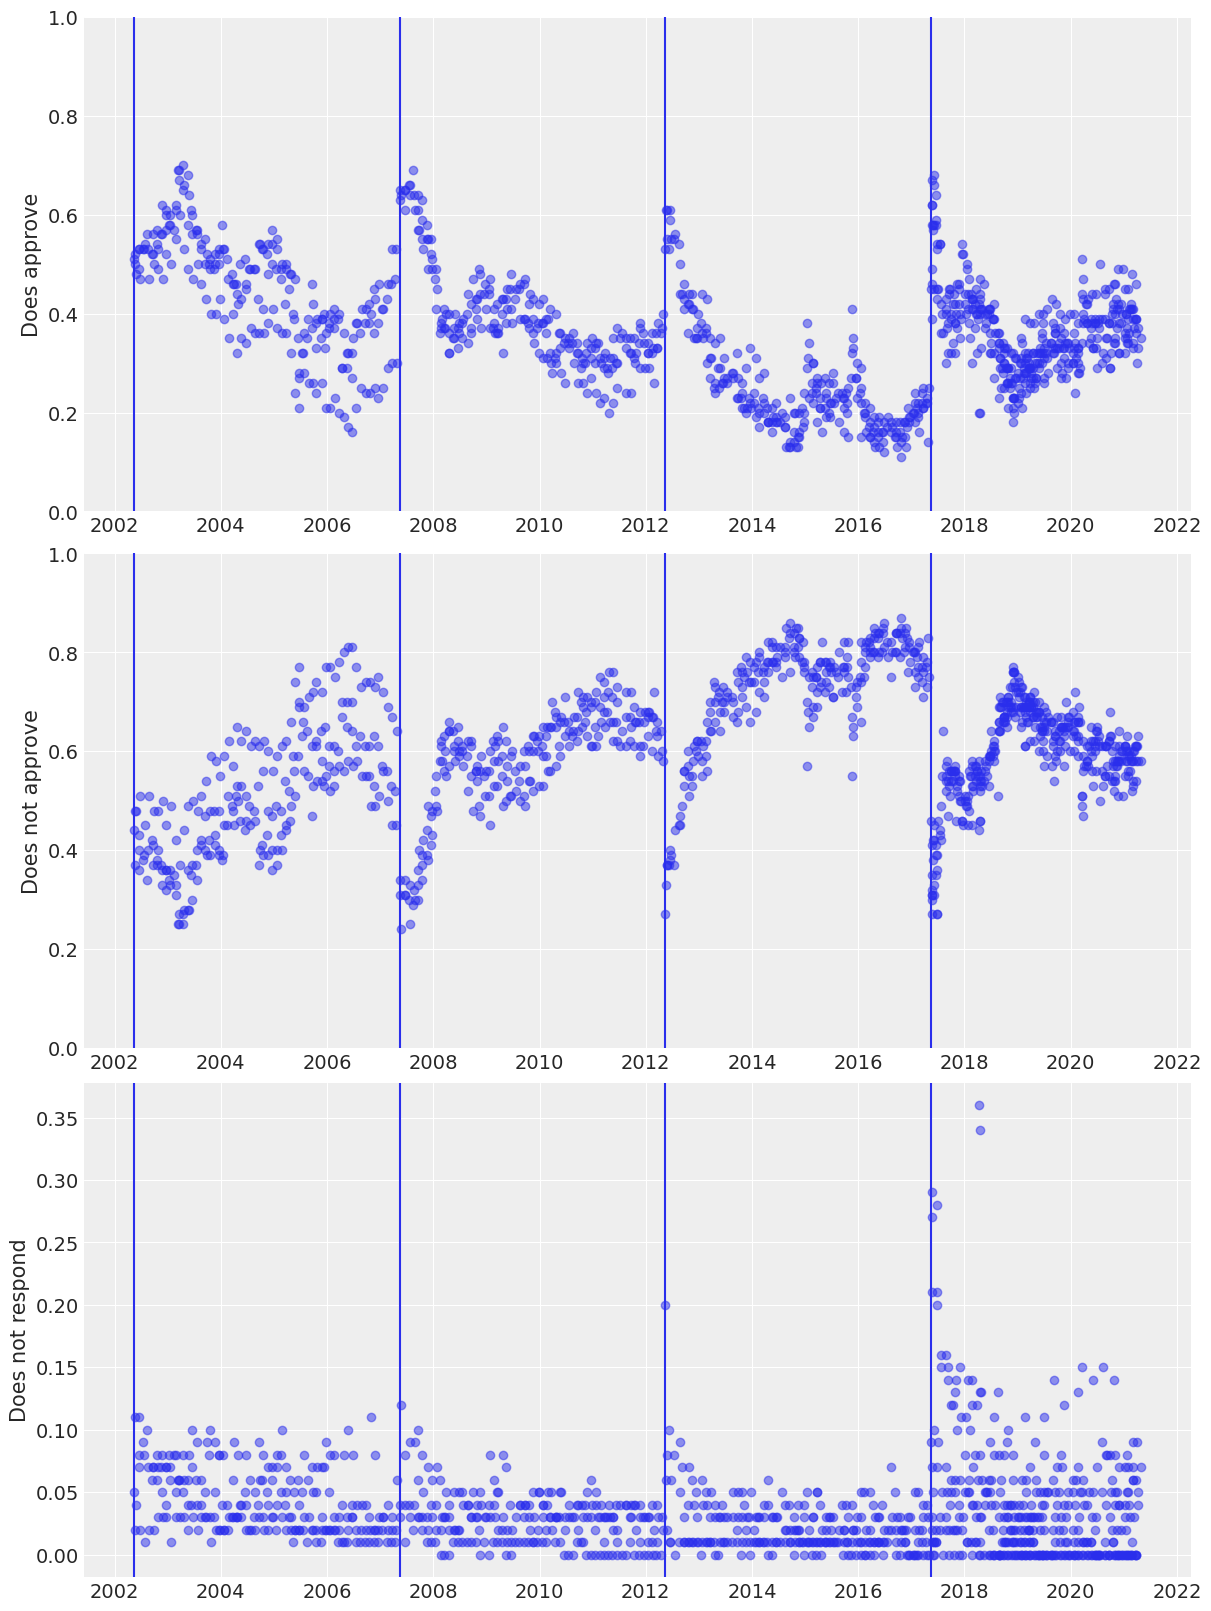

In [7]:
az.style.use("arviz-darkgrid")

approval_rates = data["p_approve"].values
disapproval_rates = data["p_disapprove"].values
newterm_dates = data.reset_index().groupby("president").first()["index"].values
doesnotrespond = 1 - approval_rates - disapproval_rates

dates = data.index

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12, 16))
ax1.plot(dates, approval_rates, "o", alpha=0.5)
ax1.set_ylim(0, 1)
ax1.set_ylabel("Does approve")
for date in newterm_dates:
    ax1.axvline(date)

ax2.plot(dates, disapproval_rates, "o", alpha=0.5)
ax2.set_ylabel("Does not approve")
ax2.set_ylim(0, 1)
for date in newterm_dates:
    ax2.axvline(date)

ax3.plot(dates, doesnotrespond, "o", alpha=0.5)
ax3.set_ylabel("Does not respond")
for date in newterm_dates:
    ax3.axvline(date)

We notice two things when looking at these plots:

1. Approval rates strikingly systematically decrease as the terms comes along;
2. While that's true, some events seem to push the approval rate back up, even though temporarily. This happened in every term, actually. Can that variance be explained solely with a random walk?
3. Non-response rate is quite high during Macron's term.

## Computing the biais: naive method

### Method bias

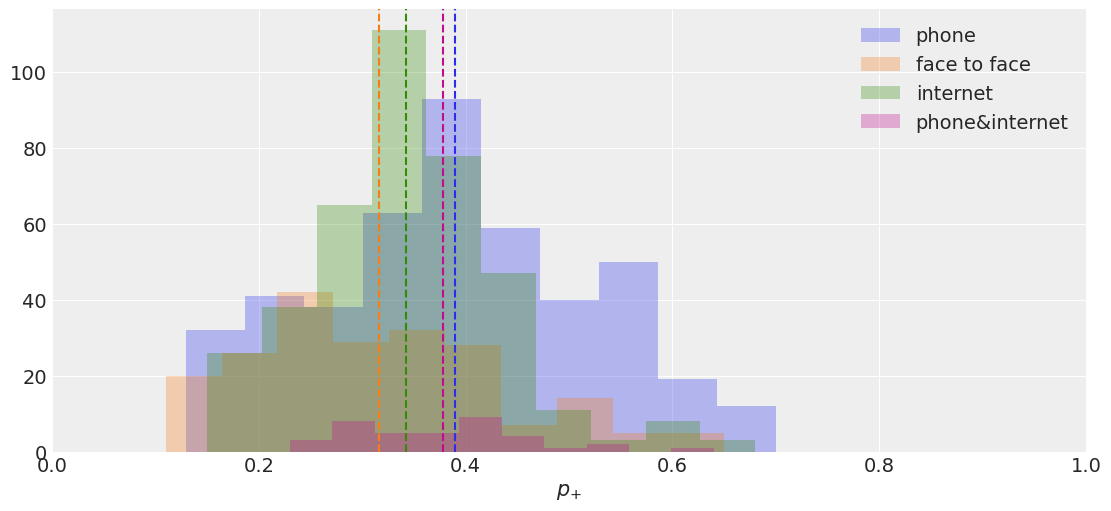

In [8]:
method_vals = {
    method: data[data["method"] == method]["p_approve"].values
    for method in list(data["method"].unique())
}

colors = plt.rcParams["axes.prop_cycle"]()
fig, ax = plt.subplots(figsize=(11, 5))

for method, vals in method_vals.items():
    c = next(colors)["color"]
    ax.hist(vals, alpha=0.3, color=c, label=method)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")

ax.set_xlim(0, 1)
ax.set_xlabel(r"$p_{+}$")
ax.legend();

### Pollster bias

We plot the distribution of the approval rates for each pollster. Note that this is not very scientific: pollsters like YouGov appeared recently so their rates will be tilted towards the last presidents' popularity while the other will be more evenly distributed.

It is already interesting to see that the bulk of the distributions is below 0.5:

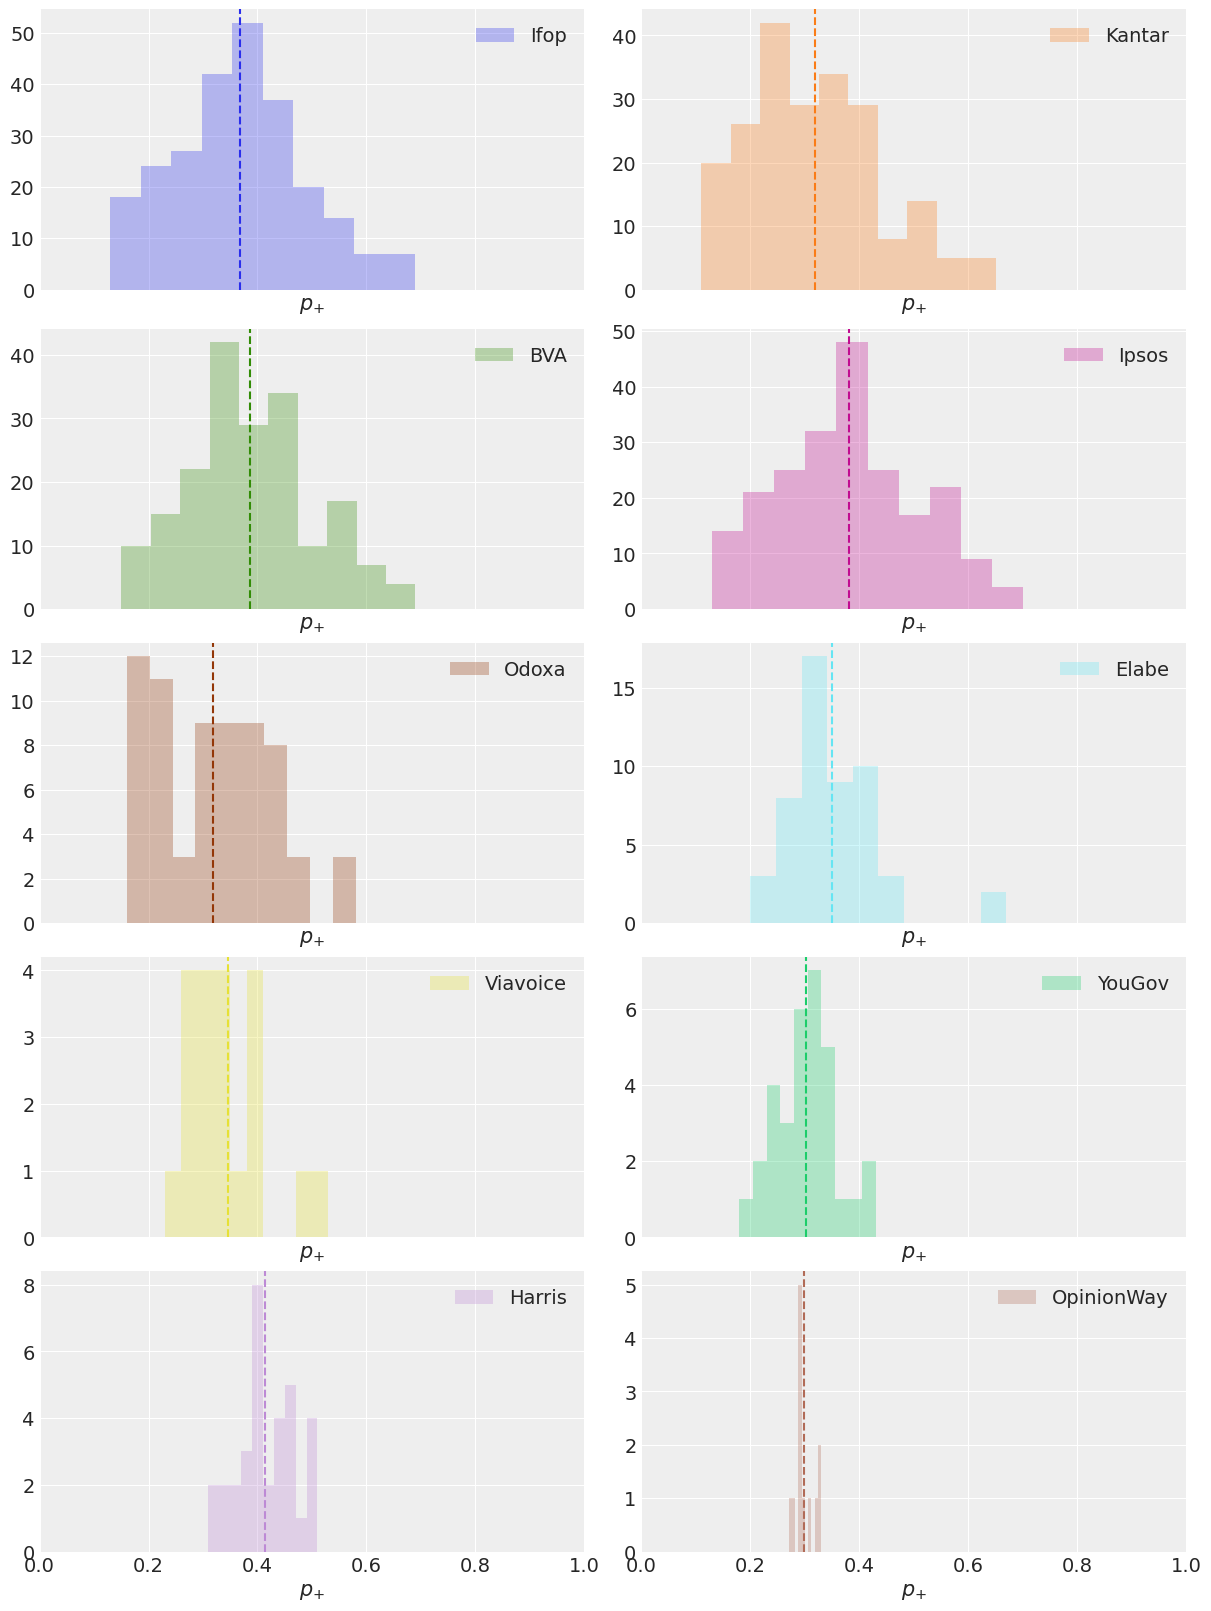

In [9]:
pollster_vals = {
    pollster: data[data["sondage"] == pollster]["p_approve"].values
    for pollster in list(pollsters)
}

colors = plt.rcParams["axes.prop_cycle"]()
fig, axes = plt.subplots(ncols=2, nrows=5, sharex=True, figsize=(12, 16))

for ax, (pollster, vals) in zip(axes.ravel(), pollster_vals.items()):
    c = next(colors)["color"]
    ax.hist(vals, alpha=0.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")
    ax.set_xlabel(r"$p_{+}$")
    ax.set_xlim(0, 1)
    ax.legend()

## Rolling standard deviation

We now compute the rolling variance of the approval rates. We weigh each poll equally, even though we probably should weigh them according to their respective sample size.

In [10]:
rolling_std = (
    data.reset_index()
    .groupby(["year", "month"])
    .std()
    .reset_index()[["year", "month", "p_approve"]]
)
rolling_std

year  month  p_approve
0    2002      5   0.017078
1    2002      6   0.030000
2    2002      7   0.005774
3    2002      8   0.045826
4    2002      9   0.025166
..    ...    ...        ...
223  2020     12   0.064627
224  2021      1   0.042661
225  2021      2   0.041748
226  2021      3   0.042980
227  2021      4   0.020000

[228 rows x 3 columns]

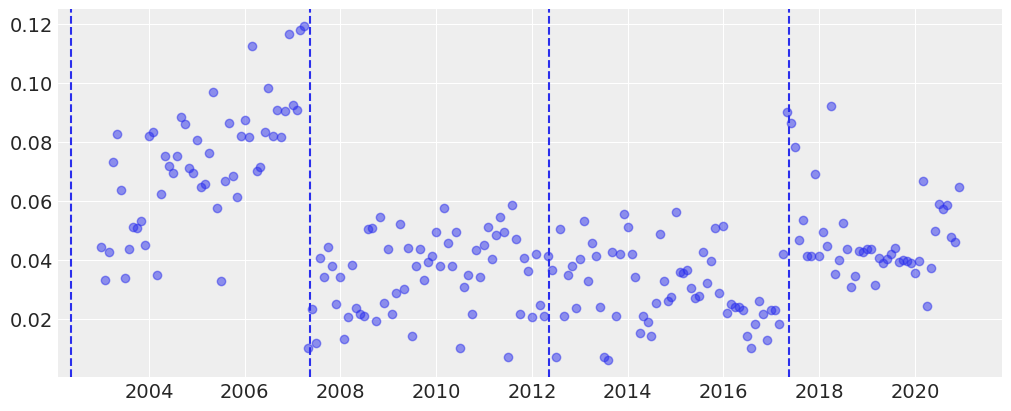

In [11]:
years = [f"{i}" for i in range(2003, 2021)]
values = rolling_std[rolling_std["year"].between(2003, 2020)]["p_approve"].values
dates = [
    datetime.datetime.strptime(f"{year}-{month}", "%Y-%m")
    for year in years
    for month in range(1, 13)
]

newterm_dates = data.reset_index().groupby("president").first()["index"].values

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dates, values, "o", alpha=0.5)
for date in newterm_dates:
    ax.axvline(date, linestyle="--")

There is an abnormally high variance for Chirac's second term, and for the beggining of Macron's term. As a matter of fact, the previous scatterplot of $p_{approve}$ clearly shows almost two different curves. Let's look at the data for Chirac's term directly:

In [12]:
chirac = data[data["president"] == "chirac2"]
chirac2007 = chirac[chirac["year"] >= 2006]
chirac2007

president sondage  samplesize        method  p_approve  \
2006-01-16   chirac2    Ifop         905         phone       0.37   
2006-01-17   chirac2   Ipsos         987         phone       0.38   
2006-01-19   chirac2     BVA        1043         phone       0.40   
2006-01-24   chirac2  Kantar         911  face to face       0.21   
2006-02-18   chirac2     BVA         953         phone       0.39   
2006-02-19   chirac2   Ipsos         971         phone       0.41   
2006-02-20   chirac2    Ifop         971         phone       0.37   
2006-02-26   chirac2  Kantar         933  face to face       0.23   
2006-03-17   chirac2    Ifop         982         phone       0.39   
2006-03-21   chirac2   Ipsos        1062         phone       0.40   
2006-03-27   chirac2  Kantar         914  face to face       0.20   
2006-04-11   chirac2   Ipsos        1097         phone       0.29   
2006-04-17   chirac2    Ifop         905         phone       0.29   
2006-04-26   chirac2     BVA        1055         phone       0.36   
2006-04-28   chirac2  Kantar        1031  face to face       0.19   
2006-05-16   chirac2    Ifop         964         phone       0.29   
2006-05-17   chirac2   Ipsos        1068         phone       0.32   
2006-05-25   chirac2  Kantar         991  face to face       0.17   
2006-05-26   chirac2     BVA        1096         phone       0.32   
2006-06-18   chirac2    Ifop         927         phone       0.27   
2006-06-18   chirac2   Ipsos        1023         phone       0.32   
2006-06-21   chirac2  Kantar        1092  face to face       0.16   
2006-06-27   chirac2     BVA         972         phone       0.35   
2006-07-16   chirac2    Ifop         958         phone       0.38   
2006-07-22   chirac2  Kantar         993  face to face       0.21   
2006-07-23   chirac2   Ipsos         984         phone       0.38   
2006-08-15   chirac2    Ifop        1074         phone       0.36   
2006-08-24   chirac2  Kantar        1019  face to face       0.25   
2006-08-26   chirac2   Ipsos         904         phone       0.41   
2006-09-20   chirac2    Ifop        1022         phone       0.38   
2006-09-24   chirac2   Ipsos         956         phone       0.41   
2006-09-24   chirac2  Kantar        1084  face to face       0.24   
2006-10-18   chirac2   Ipsos        1038         phone       0.42   
2006-10-19   chirac2    Ifop        1100         phone       0.38   
2006-10-23   chirac2  Kantar        1084  face to face       0.24   
2006-10-28   chirac2     BVA        1034         phone       0.40   
2006-11-17   chirac2    Ifop         971         phone       0.36   
2006-11-23   chirac2   Ipsos        1079         phone       0.45   
2006-11-24   chirac2     BVA         900         phone       0.43   
2006-11-25   chirac2  Kantar        1037  face to face       0.25   
2006-12-19   chirac2    Ifop         941         phone       0.38   
2006-12-20   chirac2  Kantar        1091  face to face       0.23   
2006-12-24   chirac2   Ipsos        1036         phone       0.46   
2007-01-15   chirac2    Ifop        1041         phone       0.41   
2007-01-20   chirac2   Ipsos        1018         phone       0.41   
2007-01-20   chirac2  Kantar        1098  face to face       0.25   
2007-02-15   chirac2    Ifop        1013         phone       0.43   
2007-02-22   chirac2   Ipsos        1024         phone       0.46   
2007-02-22   chirac2  Kantar        1013  face to face       0.29   
2007-03-15   chirac2    Ifop        1026         phone       0.46   
2007-03-24   chirac2  Kantar         950  face to face       0.30   
2007-03-25   chirac2   Ipsos         992         phone       0.53   
2007-04-15   chirac2    Ifop         969         phone       0.47   
2007-04-22   chirac2   Ipsos        1011         phone       0.53   
2007-04-25   chirac2  Kantar         904  face to face       0.30   

            p_disapprove  year  month  
2006-01-16          0.61  2006      1  
2006-01-17          0.57  2006      1  
2006-01-19          0.52  

And now for the beggining of Macron's term:

In [13]:
macron = data[data["president"] == "macron"]
macron2017 = macron[macron["year"] == 2017]
macron2017.head(20)

president   sondage  samplesize          method  p_approve  \
2017-05-17    macron     Elabe         999        internet       0.45   
2017-05-20    macron      Ifop         973           phone       0.62   
2017-05-20    macron     Ipsos        1015        internet       0.46   
2017-05-21    macron  Viavoice        1006        internet       0.49   
2017-05-23    macron       BVA        1011        internet       0.62   
2017-05-23    macron     Odoxa        1014        internet       0.58   
2017-05-24    macron     Elabe        1051        internet       0.67   
2017-05-25    macron    YouGov        1008        internet       0.39   
2017-05-27    macron     Ipsos        2138        internet       0.58   
2017-05-27    macron    Kantar        1008    face to face       0.57   
2017-06-04    macron       BVA        4772        internet       0.68   
2017-06-06    macron     Elabe        1001        internet       0.45   
2017-06-07    macron     Elabe        1000        internet       0.66   
2017-06-09    macron     Ipsos        4003        internet       0.58   
2017-06-19    macron      Ifop        1883  phone&internet       0.64   
2017-06-20    macron       BVA        1187        internet       0.59   
2017-06-22    macron     Odoxa        1008        internet       0.58   
2017-06-24    macron     Ipsos        1058        internet       0.45   
2017-06-24    macron    Kantar        1000    face to face       0.54   
2017-06-25    macron  Viavoice        1011        internet       0.53   

            p_disapprove  year  month  
2017-05-17          0.46  2017      5  
2017-05-20          0.31  2017      5  
2017-05-20          0.27  2017      5  
2017-05-21          0.30  2017      5  
2017-05-23          0.35  2017      5  
2017-05-23          0.41  2017      5  
2017-05-24          0.31  2017      5  
2017-05-25          0.32  2017      5  
2017-05-27          0.42  2017      5  
2017-05-27          0.38  2017      5  
2017-06-04          0.31  2017      6  
2017-06-06          0.45  2017      6  
2017-06-07          0.33  2017      6  
2017-06-09          0.42  2017      6  
2017-06-19          0.35  2017      6  
2017-06-20          0.39  2017      6  
2017-06-22          0.41  2017      6  
2017-06-24          0.27  2017      6  
2017-06-24          0.39  2017      6  
2017-06-25          0.27  2017      6

For Chirac's term it seems that difference stems from the polling method; face-to-face approval rates seem to be much lower. Let's visualize it:

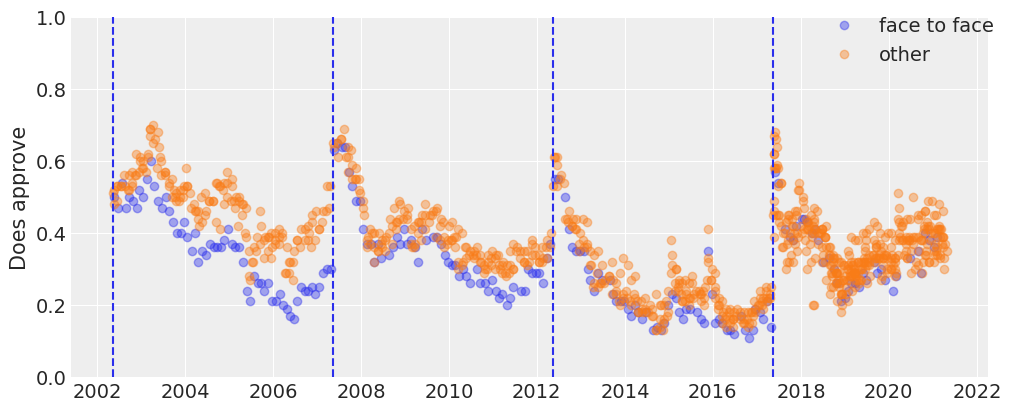

In [14]:
face = data[data["method"] == "face to face"]
dates_face = face.index

other = data[data["method"] != "face to face"]
dates_other = other.index

newterm_dates = data.reset_index().groupby("president").first()["index"].values


fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dates_face, face["p_approve"].values, "o", alpha=0.4, label="face to face")
ax.plot(dates_other, other["p_approve"].values, "o", alpha=0.4, label="other")
for date in newterm_dates:
    ax.axvline(date, linestyle="--")

ax.set_ylim(0, 1)
ax.set_ylabel("Does approve")
fig.legend();

In [15]:
data[data["sondage"] == "Kantar"]["method"].value_counts()

face to face    208
internet          4
Name: method, dtype: int64

In [16]:
data[data["method"] == "face to face"]["sondage"].value_counts()

Kantar    208
Name: sondage, dtype: int64

In [17]:
data[data["sondage"] == "Ifop"]["method"].value_counts()

phone             181
phone&internet     38
internet           29
Name: method, dtype: int64

Let us note already that since not every pollster use every method we may need to model the pairs `(pollster,method)` rather than pollsters and methods individually.

## A more serious analysis of bias

To investigate bias we now compute the rolling mean of the $p_{approve}$ values and compare each method's and pollster's deviation from the mean.

In [18]:
data = (
    data.reset_index()
    .merge(
        data.groupby(["year", "month"])["p_approve"].mean().reset_index(),
        on=["year", "month"],
        suffixes=["", "_mean"],
    )
    .rename(columns={"index": "field_date"})
)
data["diff_approval"] = data["p_approve"] - data["p_approve_mean"]
data

field_date president sondage  samplesize        method  p_approve  \
0    2002-05-15   chirac2    Ifop         924         phone       0.51   
1    2002-05-20   chirac2  Kantar         972  face to face       0.50   
2    2002-05-23   chirac2     BVA        1054         phone       0.52   
3    2002-05-26   chirac2   Ipsos         907         phone       0.48   
4    2002-06-16   chirac2    Ifop         974         phone       0.49   
...         ...       ...     ...         ...           ...        ...   
1078 2021-03-29    macron  Kantar        1000      internet       0.36   
1079 2021-03-30    macron  YouGov        1068      internet       0.30   
1080 2021-04-07    macron   Elabe        1003      internet       0.33   
1081 2021-04-10    macron   Ipsos        1002      internet       0.37   
1082 2021-04-26    macron  Kantar        1000      internet       0.35   

      p_disapprove  year  month  p_approve_mean  diff_approval  
0             0.44  2002      5        0.502500   7.500000e-03  
1             0.48  2002      5        0.502500  -2.500000e-03  
2             0.37  2002      5        0.502500   1.750000e-02  
3             0.48  2002      5        0.502500  -2.250000e-02  
4             0.43  2002      6        0.505000  -1.500000e-02  
...            ...   ...    ...             ...            ...  
1078          0.58  2021      3        0.375455  -1.545455e-02  
1079          0.61  2021      3        0.375455  -7.545455e-02  
1080          0.63  2021      4        0.350000  -2.000000e-02  
1081          0.58  2021      4        0.350000   2.000000e-02  
1082          0.58  2021      4        0.350000   5.551115e-17  

[1083 rows x 11 columns]

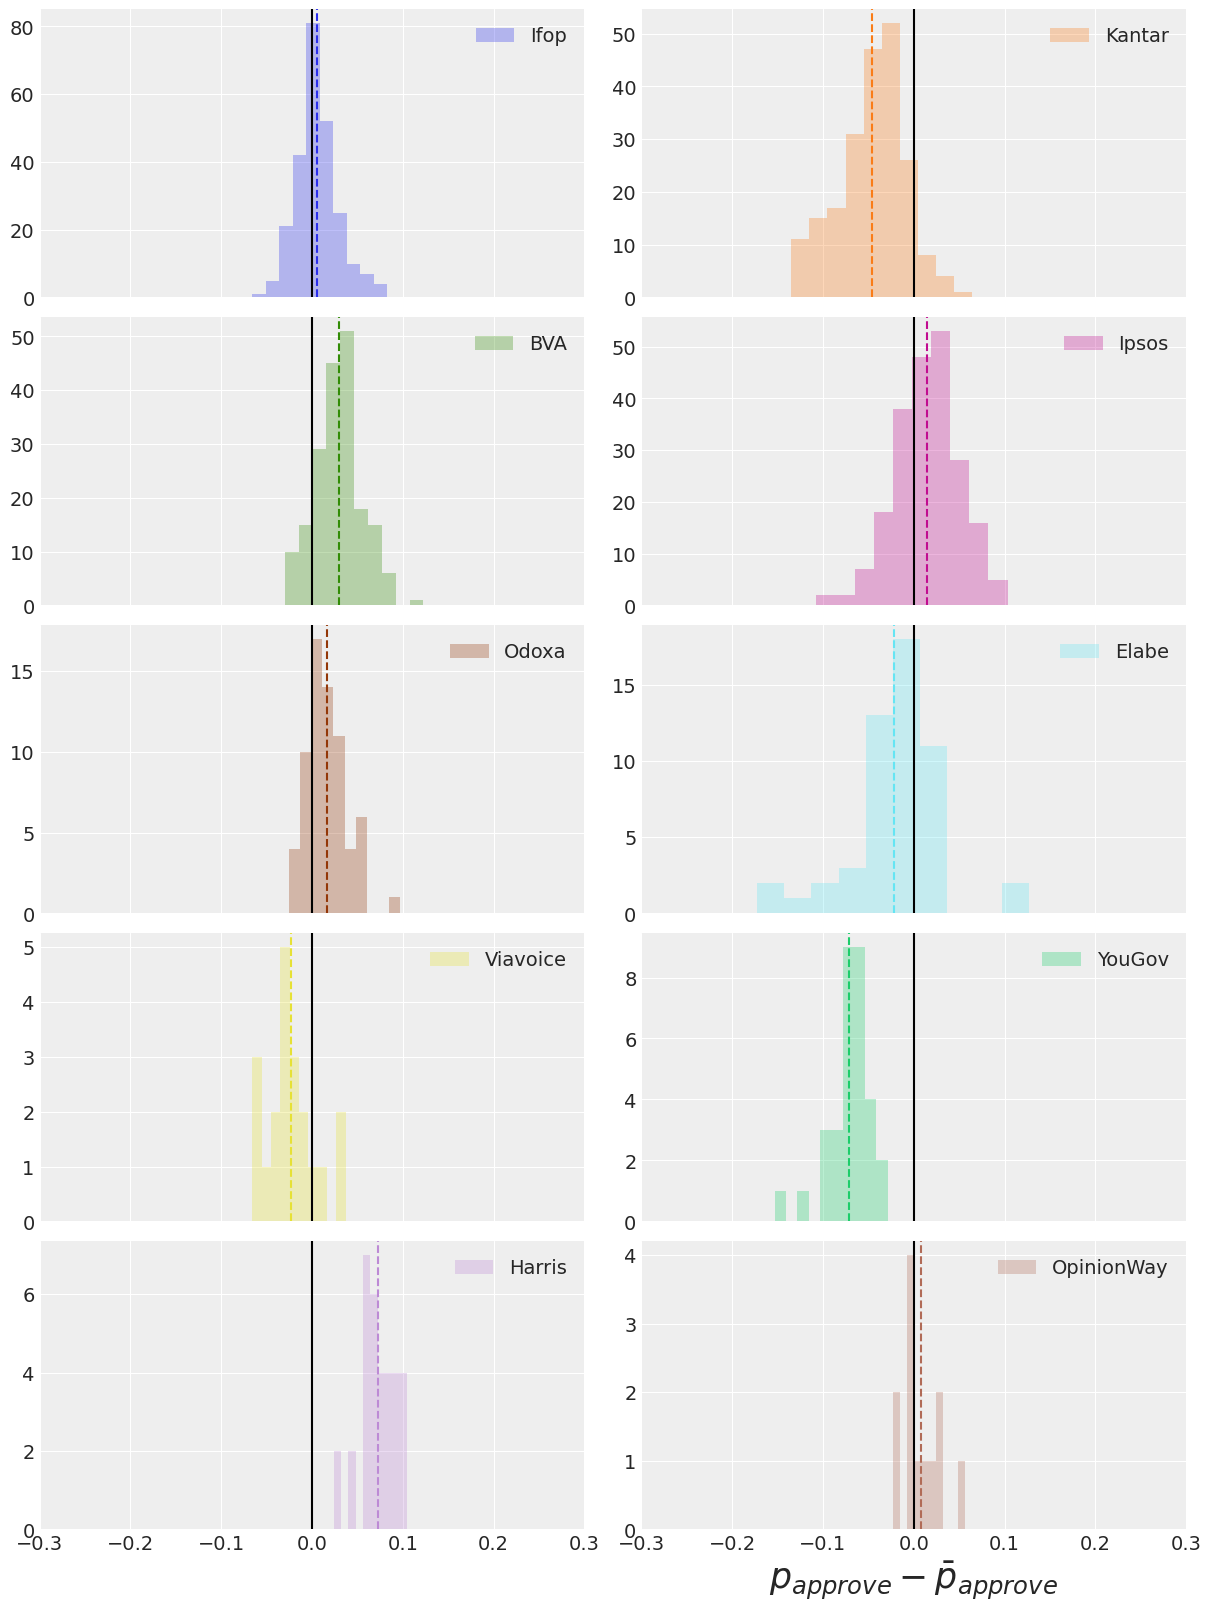

In [19]:
pollster_vals = {
    pollster: data[data["sondage"] == pollster]["diff_approval"].values
    for pollster in list(pollsters)
}

colors = plt.rcParams["axes.prop_cycle"]()
fig, axes = plt.subplots(ncols=2, nrows=5, sharex=True, figsize=(12, 16))

for ax, (pollster, vals) in zip(axes.ravel(), pollster_vals.items()):
    c = next(colors)["color"]
    ax.hist(vals, alpha=0.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")
    ax.axvline(x=0, color="black")
    ax.set_xlim(-0.3, 0.3)
    ax.legend()

plt.xlabel(r"$p_{approve} - \bar{p}_{approve}$", fontsize=25);

And now for the bias per method:

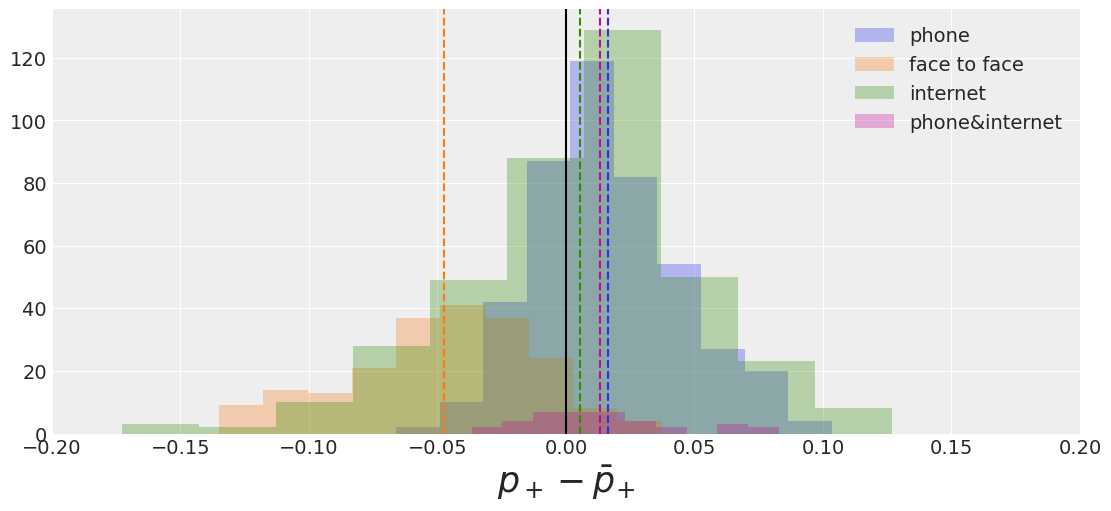

In [20]:
method_vals = {
    method: data[data["method"] == method]["diff_approval"].values
    for method in list(data["method"].unique())
}

colors = plt.rcParams["axes.prop_cycle"]()
fig, ax = plt.subplots(figsize=(11, 5))

for method, vals in method_vals.items():
    c = next(colors)["color"]
    ax.hist(vals, alpha=0.3, color=c, label=method)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")

ax.axvline(x=0, color="black")
ax.set_xlim(-0.2, 0.2)
ax.set_xlabel(r"$p_+ - \bar{p}_{+}$", fontsize=25)
ax.legend();

Face-to-face polls seems to give systematically below-average approval rates.

### TODO: Trend

Look at the successive difference of the average approval rate. Is there a trend
here?

# Model

Each poll $i$ at month $m$ from the beginning of a president’s term finds that
$y_i$ individuals have a positive opinion of the president’s action over
$n_i$ respondents. We model this as

$$y_{i,m} \sim Binomial(p_{i,m}, n_{i,m})$$

We loosely call $p_{i,m}$ the *popularity* of the president, $m$ month into his
presidency. This is the quantity we would like to model.

Why specify the month when the time information is already contained in the
succession of polls? Because French people tend to be less and less satisfied
with their president as their term moves, regardless of their action.

We model $p_{i,m}$ with a random walk logistic regression:

$$p_{i,m} = logit^{-1}(\mu_m + \alpha_k + \zeta_j)$$

$\mu_m$ is the underlying support for the president at month $m$. $\alpha_k$ is
the bias of the pollster, while $\zeta_j$ is the inherent bias of the polling
method. The biases are assumed to be completely unpooled at first, i.e we model
one bias for each pollster and method:

$$\alpha_k \sim Normal(0, \sigma_k)\qquad \forall pollster k$$

and 

$$\zeta_j \sim Normal(0, \sigma_j)\qquad \forall method j$$

We treat the time variation of $\mu$ with a correlated random walk:

$$\mu_m | \mu_{m-1} \sim Normal(\mu_{m-1}, \sigma_m)$$

For the sake of simplicity, we choose not to account at first for a natural
decline in popularity $\delta$, the unmeployment at month $m$, $U_m$, or
random events that can happen during the term. 

In [21]:
data["num_approve"] = np.floor(data["samplesize"] * data["p_approve"]).astype("int")
data

field_date president sondage  samplesize        method  p_approve  \
0    2002-05-15   chirac2    Ifop         924         phone       0.51   
1    2002-05-20   chirac2  Kantar         972  face to face       0.50   
2    2002-05-23   chirac2     BVA        1054         phone       0.52   
3    2002-05-26   chirac2   Ipsos         907         phone       0.48   
4    2002-06-16   chirac2    Ifop         974         phone       0.49   
...         ...       ...     ...         ...           ...        ...   
1078 2021-03-29    macron  Kantar        1000      internet       0.36   
1079 2021-03-30    macron  YouGov        1068      internet       0.30   
1080 2021-04-07    macron   Elabe        1003      internet       0.33   
1081 2021-04-10    macron   Ipsos        1002      internet       0.37   
1082 2021-04-26    macron  Kantar        1000      internet       0.35   

      p_disapprove  year  month  p_approve_mean  diff_approval  num_approve  
0             0.44  2002      5        0.502500   7.500000e-03          471  
1             0.48  2002      5        0.502500  -2.500000e-03          486  
2             0.37  2002      5        0.502500   1.750000e-02          548  
3             0.48  2002      5        0.502500  -2.250000e-02          435  
4             0.43  2002      6        0.505000  -1.500000e-02          477  
...            ...   ...    ...             ...            ...          ...  
1078          0.58  2021      3        0.375455  -1.545455e-02          360  
1079          0.61  2021      3        0.375455  -7.545455e-02          320  
1080          0.63  2021      4        0.350000  -2.000000e-02          330  
1081          0.58  2021      4        0.350000   2.000000e-02          370  
1082          0.58  2021      4        0.350000   5.551115e-17          350  

[1083 rows x 12 columns]

In [22]:
pd.crosstab(data.sondage, data.method)

method      face to face  internet  phone  phone&internet
sondage                                                  
BVA                    0       101     89               0
Elabe                  0        52      0               0
Harris                 0        33      0               0
Ifop                   0        29    181              38
Ipsos                  0        40    177               0
Kantar               208         4      0               0
Odoxa                  0        67      0               0
OpinionWay             0        12      0               0
Viavoice               0        20      0               0
YouGov                 0        32      0               0

We can only estimate the bias for internet and phone, not for face-to-face and phone&internet, as they are only conducted by one pollster (Kantar and Ifop respectively). Similarly, we can use an interaction term only for those pollsters which use more than one method, i.e BVA, Ifop and Ipsos.

Each observation is uniquely identified by `(pollster, field_date)`:

In [23]:
pollster_by_method_id, pollster_by_methods = data.set_index(
    ["sondage", "method"]
).index.factorize(sort=True)
month_id = np.hstack(
    [
        pd.Categorical(
            data[data.president == president].field_date.dt.to_period("M")
        ).codes
        for president in data.president.unique()
    ]
)
months = np.arange(max(month_id) + 1)

In [24]:
COORDS = {
    "pollster_by_method": pollster_by_methods,
    "month": months,
    "observation": data.set_index(["sondage", "field_date"]).index,
}

### Fixed `mu` for GRW

In [25]:
with pm.Model(coords=COORDS) as pooled_popularity:

    bias = pm.Normal("bias", 0, 0.15, dims="pollster_by_method")
    mu = pm.GaussianRandomWalk("mu", sigma=1.0, dims="month")

    popularity = pm.Deterministic(
        "popularity",
        pm.math.invlogit(
            mu[month_id] + bias[pollster_by_method_id]
        ),
        dims="observation",
    )

    N_approve = pm.Binomial(
        "N_approve",
        p=popularity,
        n=data["samplesize"],
        observed=data["num_approve"],
        dims="observation",
    )

    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, bias]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


0, dim: observation, 1083 =? 1083


The acceptance probability does not match the target. It is 0.9014060816368271, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


We plot the posterior distribution of the pollster and method biases:

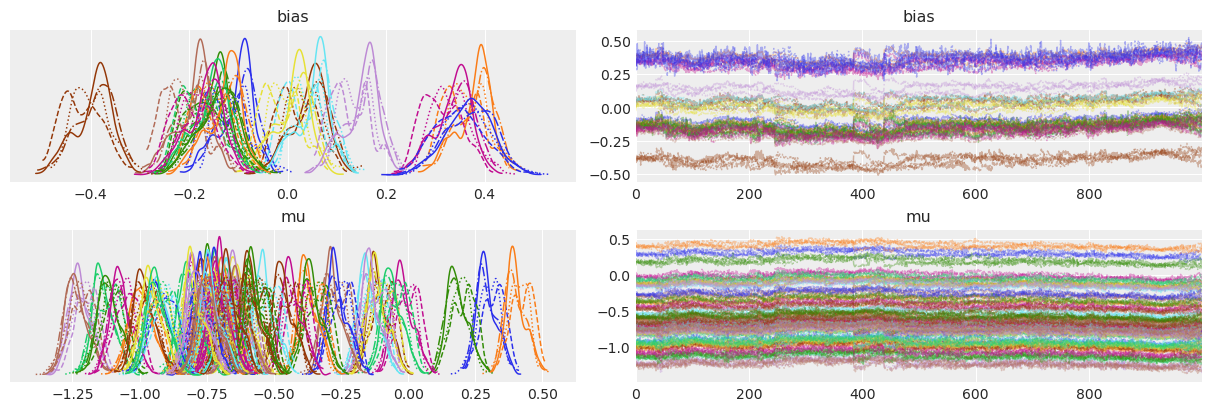

In [26]:
az.plot_trace(idata, var_names=["~popularity"], compact=True);

Since we are performing a logistic regression, these coefficients can be tricky to interpret. When the bias is positive, this means that we need to add to the latent popularity to get the observation, which means that the pollster/method tends to be biased towards giving higher popularity scores.

In [27]:
az.summary(idata, round_to=2, var_names=["~popularity"])

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
bias[0] -0.11  0.04   -0.18    -0.04       0.01     0.01     15.48     72.87   
bias[1]  0.37  0.04    0.30     0.45       0.01     0.01     16.07     51.20   
bias[2] -0.16  0.04   -0.23    -0.09       0.01     0.01     16.72     76.21   
bias[3]  0.33  0.04    0.25     0.40       0.01     0.01     16.97     62.54   
bias[4]  0.04  0.04   -0.03     0.11       0.01     0.01     16.83     57.66   
...       ...   ...     ...      ...        ...      ...       ...       ...   
mu[55]  -0.92  0.05   -1.01    -0.84       0.01     0.01     19.60    104.48   
mu[56]  -0.95  0.04   -1.03    -0.87       0.01     0.01     18.76     96.28   
mu[57]  -0.93  0.04   -1.01    -0.85       0.01     0.01     19.67     84.27   
mu[58]  -0.77  0.04   -0.85    -0.69       0.01     0.01     19.60     61.70   
mu[59]  -0.74  0.04   -0.82    -0.66       0.01     0.01     19.51     94.74   

         r_hat  
bias[0]   1.21  
bias[1]   1.20  
bias[2]   1.19  
bias[3]   1.19  
bias[4]   1.19  
...        ...  
mu[55]    1.16  
mu[56]    1.16  
mu[57]    1.15  
mu[58]    1.15  
mu[59]    1.16  

[75 rows x 9 columns]

In [28]:
mean_bias = idata.posterior["bias"].mean(("chain", "draw")).to_dataframe()
mean_bias.round(2)

bias
pollster_by_method_level_0 pollster_by_method_level_1      
BVA                        internet                   -0.11
                           phone                       0.37
Elabe                      internet                   -0.16
Harris                     internet                    0.33
Ifop                       internet                    0.04
                           phone                       0.05
                           phone&internet              0.00
Ipsos                      internet                   -0.16
                           phone                       0.14
Kantar                     face to face               -0.20
                           internet                    0.36
Odoxa                      internet                   -0.13
OpinionWay                 internet                   -0.15
Viavoice                   internet                   -0.18
YouGov                     internet                   -0.40

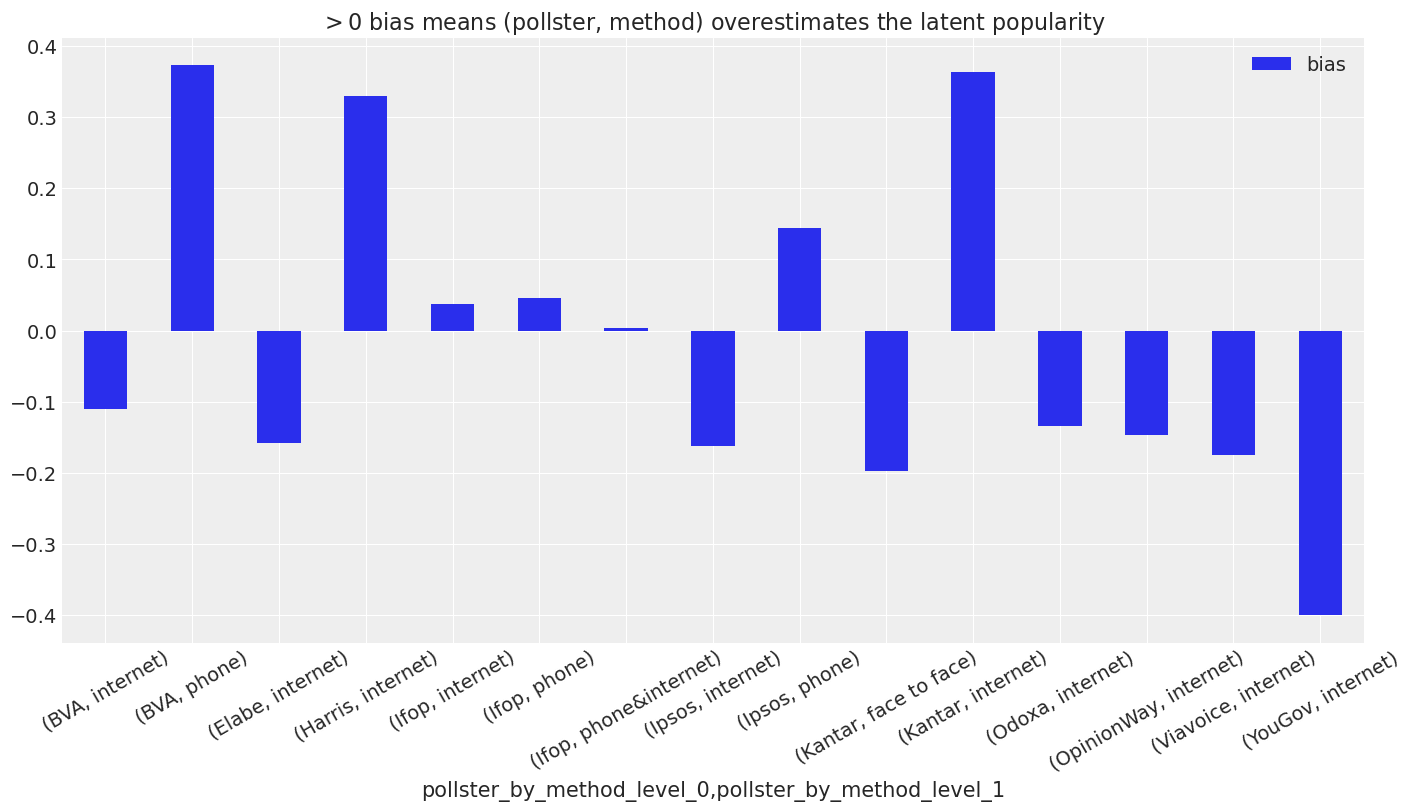

In [29]:
ax = mean_bias.plot.bar(figsize=(14, 8), rot=30)
ax.set_title("$>0$ bias means (pollster, method) overestimates the latent popularity");

We now plot the posterior values of `mu`. Since the model is completely pooled, we only have 60 values, which correspond to a full term:

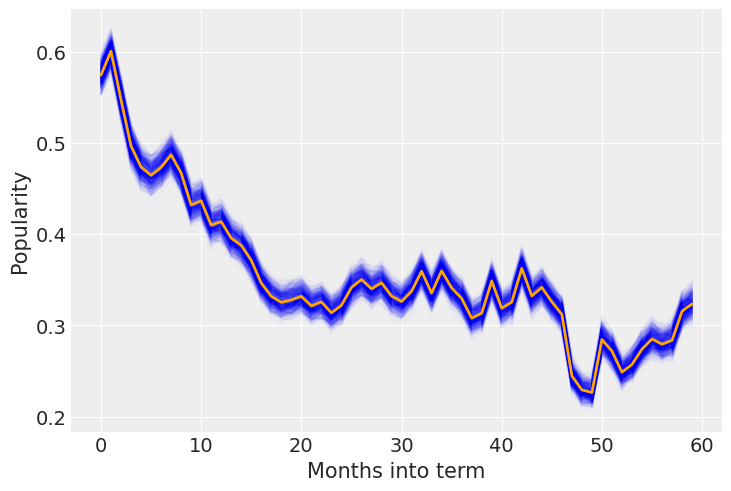

In [30]:
post_pop = logistic(idata.posterior["mu"].stack(sample=("chain", "draw")))

fig, ax = plt.subplots()
for i in np.random.choice(post_pop.coords["sample"].size, size=1000):
    ax.plot(
        idata.posterior.coords["month"],
        post_pop.isel(sample=i),
        alpha=0.01,
        color="blue",
    )
post_pop.mean("sample").plot(ax=ax, color="orange", lw=2)
ax.set_ylabel("Popularity")
ax.set_xlabel("Months into term");

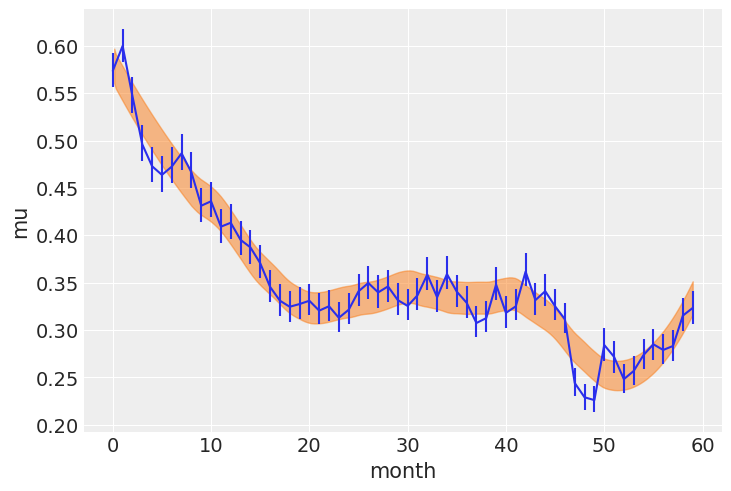

In [31]:
hdi_data = az.hdi(logistic(idata.posterior["mu"]))
ax = az.plot_hdi(idata.posterior.coords["month"], hdi_data=hdi_data)
ax.vlines(
    idata.posterior.coords["month"],
    hdi_data.sel(hdi="lower")["mu"],
    hdi_data.sel(hdi="higher")["mu"],
)
post_pop.median("sample").plot(ax=ax);

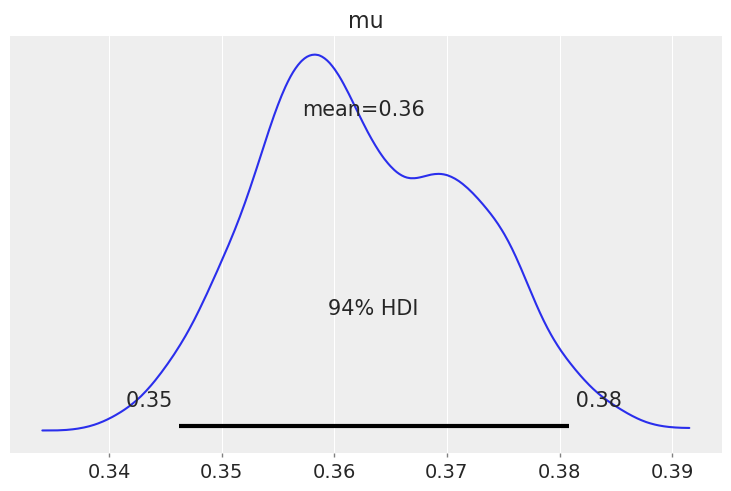

In [32]:
az.plot_posterior(logistic(idata.posterior["mu"].sel(month=42)));

### Infer the standard deviation $\sigma$ of the random walk

In [33]:
with pm.Model(coords=COORDS) as pooled_popularity:

    bias = pm.Normal("bias", 0, 0.15, dims="pollster_by_method")
    sigma_mu = pm.HalfNormal("sigma_mu", 0.5)
    mu = pm.GaussianRandomWalk("mu", sigma=sigma_mu, dims="month")

    popularity = pm.Deterministic(
        "popularity",
        pm.math.invlogit(mu[month_id] + bias[pollster_by_method_id]),
        dims="observation",
    )

    N_approve = pm.Binomial(
        "N_approve",
        p=popularity,
        n=data["samplesize"],
        observed=data["num_approve"],
        dims="observation",
    )

    idata = pm.sample(tune=2000, draws=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma_mu, bias]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 30 seconds.


0, dim: observation, 1083 =? 1083


There were 1913 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.09583612432314655, but should be close to 0.8. Try to increase the number of tuning steps.
There were 329 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.20431565460109227, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


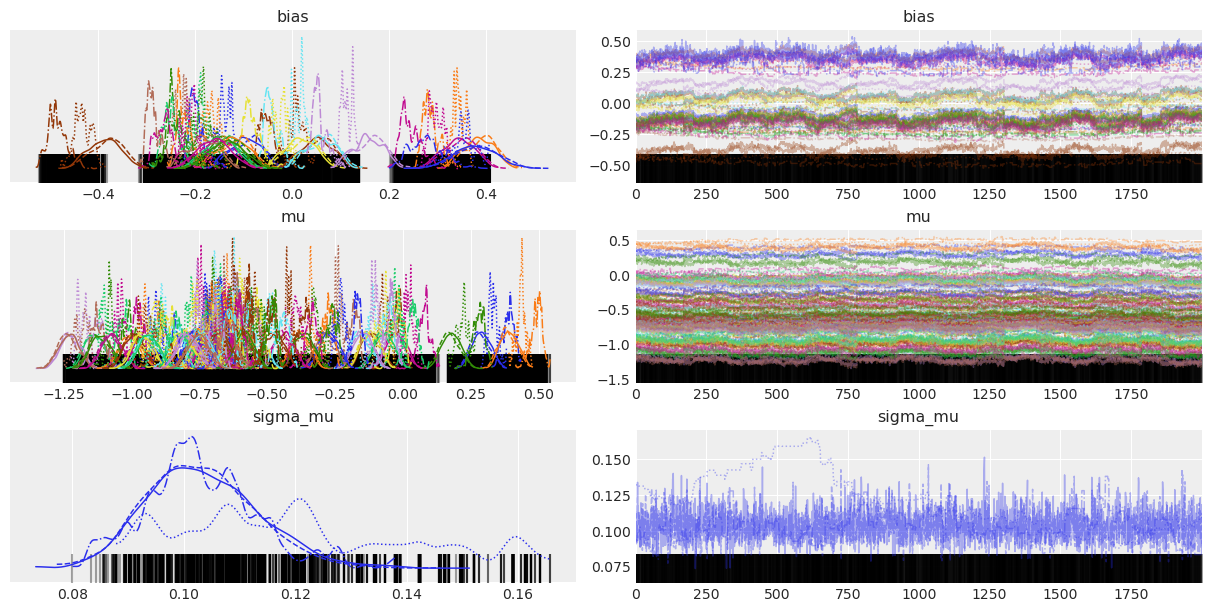

In [34]:
az.plot_trace(idata, var_names=["~popularity"], compact=True);

In [35]:
az.summary(idata, round_to=2, var_names=["~popularity"])

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
bias[0]  -0.13  0.05   -0.21    -0.05       0.02     0.02      5.78     14.17   
bias[1]   0.35  0.05    0.26     0.43       0.02     0.02      5.77     16.87   
bias[2]  -0.18  0.05   -0.26    -0.09       0.02     0.02      5.81     24.20   
bias[3]   0.31  0.05    0.22     0.39       0.02     0.02      5.83     23.19   
bias[4]   0.02  0.05   -0.07     0.10       0.02     0.02      5.91     22.67   
...        ...   ...     ...      ...        ...      ...       ...       ...   
mu[56]   -0.93  0.05   -1.02    -0.84       0.02     0.01      6.28     37.49   
mu[57]   -0.90  0.05   -0.98    -0.79       0.02     0.02      6.24     35.15   
mu[58]   -0.76  0.05   -0.84    -0.66       0.02     0.02      6.16     39.63   
mu[59]   -0.71  0.05   -0.81    -0.62       0.02     0.02      6.17     34.68   
sigma_mu  0.11  0.02    0.08     0.14       0.01     0.00     11.93     22.43   

          r_hat  
bias[0]    1.89  
bias[1]    1.90  
bias[2]    1.87  
bias[3]    1.86  
bias[4]    1.84  
...         ...  
mu[56]     1.72  
mu[57]     1.73  
mu[58]     1.75  
mu[59]     1.75  
sigma_mu   1.26  

[76 rows x 9 columns]

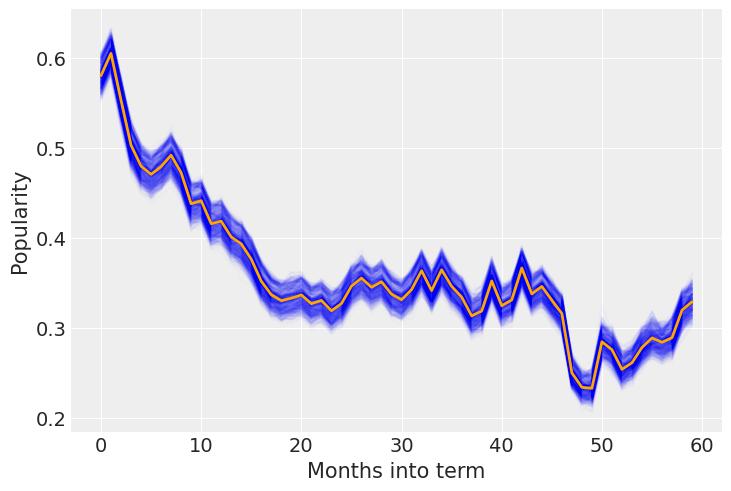

In [36]:
post_pop = logistic(idata.posterior["mu"].stack(sample=("chain", "draw")))

fig, ax = plt.subplots()
for i in np.random.choice(post_pop.coords["sample"].size, size=1000):
    ax.plot(
        idata.posterior.coords["month"],
        post_pop.isel(sample=i),
        alpha=0.01,
        color="blue",
    )
post_pop.mean("sample").plot(ax=ax, color="orange", lw=2)
ax.set_ylabel("Popularity")
ax.set_xlabel("Months into term");

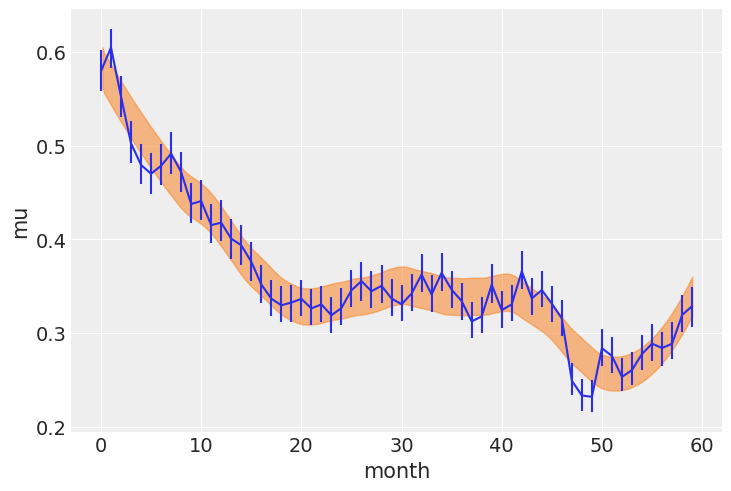

In [37]:
hdi_data = az.hdi(logistic(idata.posterior["mu"]))
ax = az.plot_hdi(idata.posterior.coords["month"], hdi_data=hdi_data)
ax.vlines(
    idata.posterior.coords["month"],
    hdi_data.sel(hdi="lower")["mu"],
    hdi_data.sel(hdi="higher")["mu"],
)
post_pop.median("sample").plot(ax=ax);

The posterior variance of the values of $\mu$ looks grossly underestimated; between month 40 and 50 presidents have had popularity rates between .2 nd .4 while here the popularity is estimated aournd .21 plus or minus .02 at best. We need to fhix this.

### A model that accounts for the overdispersion of polls

As we saw with the previous model, the variance of $\mu$'s posterior values is grossly underestimated. This suggests that the variance in the obervations is not only due to variations in the mean value, $p_{approve}$. Indeed, there is variance in the results that probably cannot be accounted for by the pollsters' and method's biais and has more something to do with measurement errors, or other factors we did not include.

We use a Beta-Binomial model to add one degree of liberty and allow the variance to be estimated independantly from the mean value.

In [38]:
with pm.Model(coords=COORDS) as pooled_popularity:

    bias = pm.Normal("bias", 0, 0.15, dims="pollster_by_method")
    sigma_mu = pm.HalfNormal("sigma_mu", 0.5)
    mu = pm.GaussianRandomWalk("mu", sigma=sigma_mu, dims="month")

    popularity = pm.Deterministic(
        "popularity",
        pm.math.invlogit(mu[month_id] + bias[pollster_by_method_id]),
        dims="observation",
    )

    # overdispersion parameter
    theta = pm.Exponential("theta_offset", 1.0) + 10.0

    N_approve = pm.BetaBinomial(
        "N_approve",
        alpha=popularity * theta,
        beta=(1.0 - popularity) * theta,
        n=data["samplesize"],
        observed=data["num_approve"],
        dims="observation",
    )

    idata = pm.sample(tune=2000, draws=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_offset, mu, sigma_mu, bias]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 40 seconds.


0, dim: observation, 1083 =? 1083


The number of effective samples is smaller than 10% for some parameters.


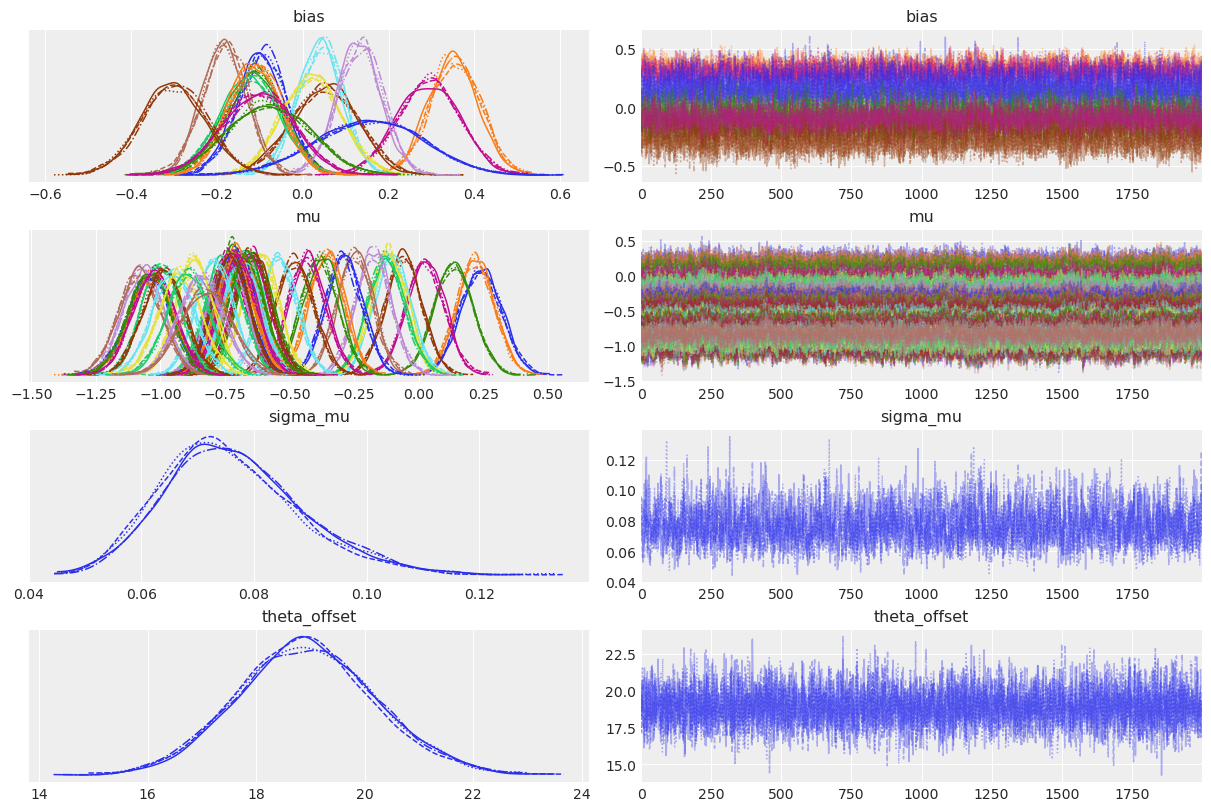

In [39]:
az.plot_trace(idata, var_names=["~popularity"], compact=True);

In [40]:
az.summary(idata, round_to=2, var_names=["~popularity"])

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
bias[0]       -0.10  0.06   -0.20     0.01       0.00     0.00    782.05   
bias[1]        0.35  0.06    0.24     0.46       0.00     0.00    868.45   
bias[2]       -0.11  0.07   -0.23     0.02       0.00     0.00   1167.09   
bias[3]        0.29  0.07    0.15     0.43       0.00     0.00   1470.48   
bias[4]        0.05  0.08   -0.09     0.20       0.00     0.00   1650.07   
...             ...   ...     ...      ...        ...      ...       ...   
mu[57]        -0.89  0.08   -1.05    -0.74       0.00     0.00   1208.78   
mu[58]        -0.84  0.09   -1.00    -0.68       0.00     0.00   1228.38   
mu[59]        -0.82  0.10   -1.00    -0.64       0.00     0.00   1601.51   
sigma_mu       0.08  0.01    0.06     0.10       0.00     0.00   1904.04   
theta_offset  18.92  1.27   16.52    21.33       0.02     0.01   7098.93   

              ess_tail  r_hat  
bias[0]        1551.12    1.0  
bias[1]        1673.33    1.0  
bias[2]        2364.44    1.0  
bias[3]        3197.69    1.0  
bias[4]        2926.52    1.0  
...                ...    ...  
mu[57]         2569.19    1.0  
mu[58]         2669.57    1.0  
mu[59]         3331.46    1.0  
sigma_mu       3687.72    1.0  
theta_offset   5884.52    1.0  

[77 rows x 9 columns]

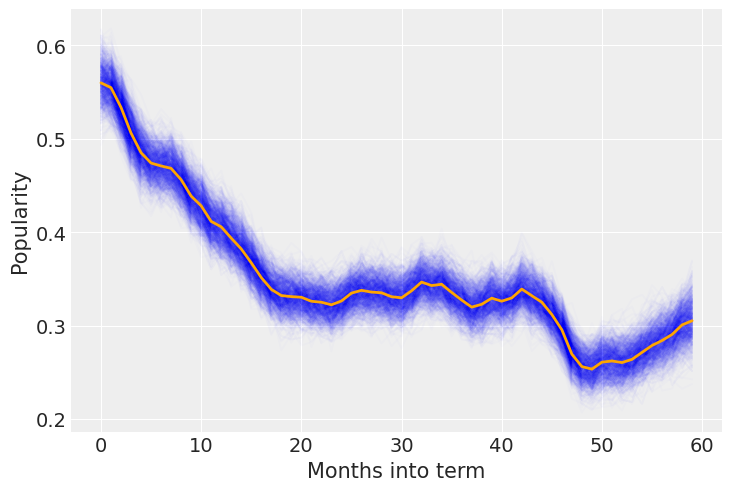

In [41]:
post_pop = logistic(idata.posterior["mu"].stack(sample=("chain", "draw")))

fig, ax = plt.subplots()
for i in np.random.choice(post_pop.coords["sample"].size, size=1000):
    ax.plot(
        idata.posterior.coords["month"],
        post_pop.isel(sample=i),
        alpha=0.01,
        color="blue",
    )
post_pop.mean("sample").plot(ax=ax, color="orange", lw=2)
ax.set_ylabel("Popularity")
ax.set_xlabel("Months into term");

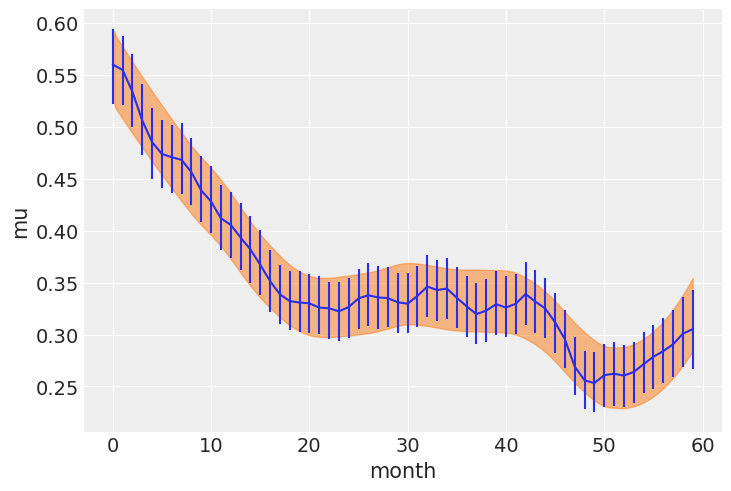

In [42]:
hdi_data = az.hdi(logistic(idata.posterior["mu"]))
ax = az.plot_hdi(idata.posterior.coords["month"], hdi_data=hdi_data)
ax.vlines(
    idata.posterior.coords["month"],
    hdi_data.sel(hdi="lower")["mu"],
    hdi_data.sel(hdi="higher")["mu"],
)
post_pop.median("sample").plot(ax=ax);

This is much better! It is unlikely we would be able to do much better than this for the unpooled model; maybe by having one dispersion term per term/month. But since we wish to switch to a partially pooled model for $\mu$ we will stop our investigation on the fully pooled model for now.

### Hierarchical model

In [43]:
president_id, presidents = data["president"].factorize(sort=False)
COORDS["president"] = presidents

In [44]:
from typing import *


def ZeroSumNormal(
    name: str,
    sigma: Optional[float] = None,
    *,
    dims: Union[str, Tuple[str]],
    model: Optional[pm.Model] = None,
):
    """
    Multivariate normal, such that sum(x, axis=-1) = 0.

    Parameters
    ----------
    name: str
        String name representation of the PyMC variable.
    sigma: Optional[float], defaults to None
        Scale for the Normal distribution. If ``None``, a standard Normal is used.
    dims: Union[str, Tuple[str]]
        Dimension names for the shape of the distribution.
        See https://docs.pymc.io/pymc-examples/examples/pymc3_howto/data_container.html for an example.
    model: Optional[pm.Model], defaults to None
        PyMC model instance. If ``None``, a model instance is created.
    """
    if isinstance(dims, str):
        dims = (dims,)

    model = pm.modelcontext(model)
    *dims_pre, dim = dims
    dim_trunc = f"{dim}_truncated_"
    (shape,) = model.shape_from_dims((dim,))
    assert shape >= 1

    model.add_coords({f"{dim}_truncated_": pd.RangeIndex(shape - 1)})
    raw = pm.Normal(
        f"{name}_truncated_", dims=tuple(dims_pre) + (dim_trunc,), sigma=sigma
    )
    Q = make_sum_zero_hh(shape)
    draws = aet.dot(raw, Q[:, 1:].T)

    # if sigma is not None:
    #    draws = sigma * draws

    return pm.Deterministic(name, draws, dims=dims)


def make_sum_zero_hh(N: int) -> np.ndarray:
    """
    Build a householder transformation matrix that maps e_1 to a vector of all 1s.
    """
    e_1 = np.zeros(N)
    e_1[0] = 1
    a = np.ones(N)
    a /= np.sqrt(a @ a)
    v = a + e_1
    v /= np.sqrt(v @ v)
    return np.eye(N) - 2 * np.outer(v, v)

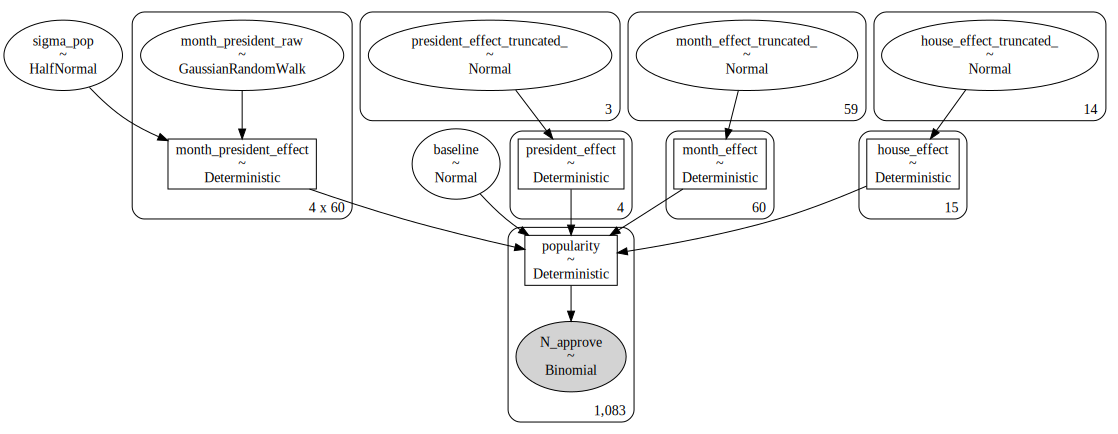

In [45]:
with pm.Model(coords=COORDS) as hierarchical_popularity:

    baseline = pm.Normal("baseline")
    president_effect = ZeroSumNormal("president_effect", sigma=0.15, dims="president")
    month_effect = ZeroSumNormal("month_effect", sigma=0.15, dims="month") # estimate with a GRW too?
    house_effect = ZeroSumNormal("house_effect", sigma=0.15, dims="pollster_by_method")
    # try to add a method coeff
    # + method_bias[method_id]
    
    sd = pm.HalfNormal("sigma_pop", 0.5)
    # try this with the cumsum approach, to properly control the init
    # try with a GP
    raw = pm.GaussianRandomWalk(
        "month_president_raw", sigma=1.0, dims=("president", "month"), init=pm.Normal.dist(sigma=0.01)
    )
    month_president_effect = pm.Deterministic("month_president_effect", raw * sd, dims=("president", "month"))

    popularity = pm.Deterministic(
        "popularity",
        pm.math.invlogit(
            baseline
            + president_effect[president_id]
            + month_effect[month_id]
            + month_president_effect[president_id, month_id]
            + house_effect[pollster_by_method_id]
        ),
        dims="observation",
    )

    N_approve = pm.Binomial(
        "N_approve",
        p=popularity,
        n=data["samplesize"],
        observed=data["num_approve"],
        dims="observation",
    )
pm.model_to_graphviz(hierarchical_popularity)

In [51]:
with hierarchical_popularity:
    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [month_president_raw, sigma_pop, house_effect_truncated_, month_effect_truncated_, president_effect_truncated_, baseline]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 100 seconds.


0, dim: observation, 1083 =? 1083


The number of effective samples is smaller than 10% for some parameters.


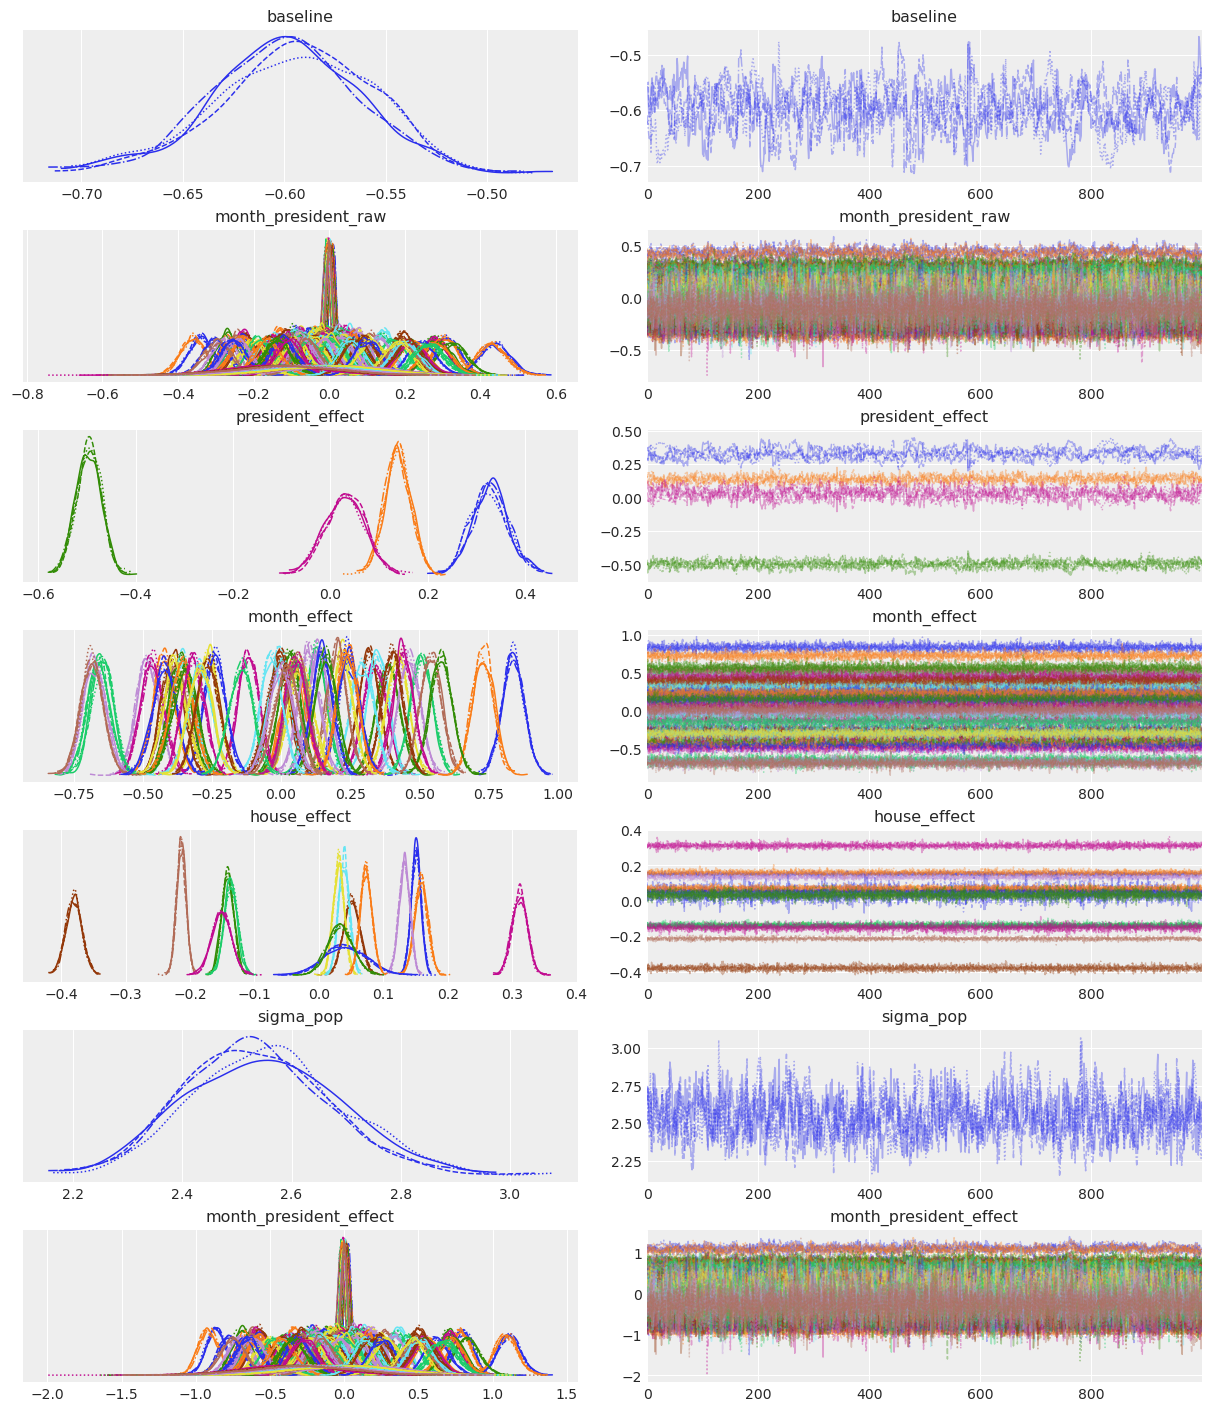

In [56]:
az.plot_trace(idata, var_names=["~popularity", "~truncated"], filter_vars="regex", compact=True);

In [58]:
az.summary(idata, round_to=2, var_names=["~popularity", "~truncated"], filter_vars="regex")

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
baseline                     -0.60  0.04   -0.67    -0.52        0.0     0.00   
month_president_raw[0,0]      0.00  0.01   -0.02     0.02        0.0     0.00   
month_president_raw[0,1]      0.00  0.01   -0.02     0.02        0.0     0.00   
month_president_raw[0,2]      0.00  0.01   -0.01     0.02        0.0     0.00   
month_president_raw[0,3]      0.00  0.01   -0.02     0.02        0.0     0.00   
...                            ...   ...     ...      ...        ...      ...   
month_president_effect[3,55] -0.07  0.34   -0.76     0.51        0.0     0.01   
month_president_effect[3,56]  0.01  0.34   -0.61     0.64        0.0     0.01   
month_president_effect[3,57] -0.22  0.34   -0.84     0.42        0.0     0.01   
month_president_effect[3,58] -0.19  0.34   -0.81     0.45        0.0     0.01   
month_president_effect[3,59] -0.29  0.34   -0.94     0.33        0.0     0.01   

                              ess_bulk  ess_tail  r_hat  
baseline                        337.83    328.31   1.01  
month_president_raw[0,0]       5329.32   3447.20   1.00  
month_president_raw[0,1]       6111.93   3407.13   1.00  
month_president_raw[0,2]       5917.20   3167.07   1.00  
month_president_raw[0,3]       6146.28   3475.04   1.00  
...                                ...       ...    ...  
month_president_effect[3,55]   5182.26   2995.42   1.00  
month_president_effect[3,56]   5640.36   2759.13   1.00  
month_president_effect[3,57]   5651.57   2834.44   1.00  
month_president_effect[3,58]   5845.66   2538.93   1.00  
month_president_effect[3,59]   4864.66   2632.97   1.00  

[561 rows x 9 columns]

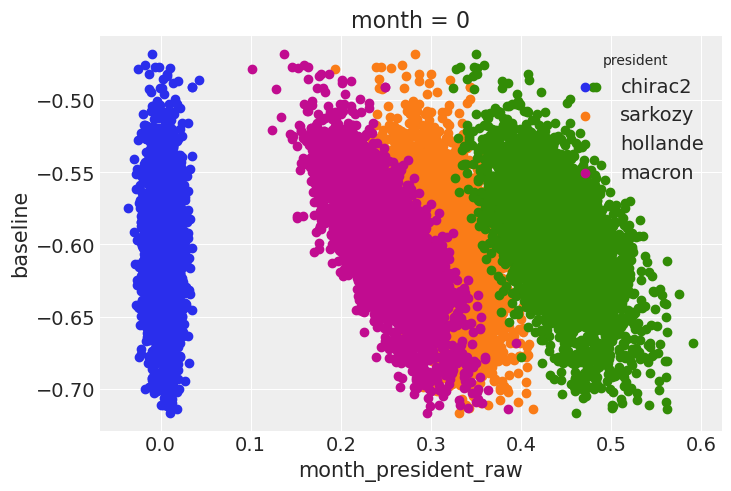

In [59]:
idata.posterior.isel(month=0).plot.scatter("month_president_raw", "baseline", hue="president");

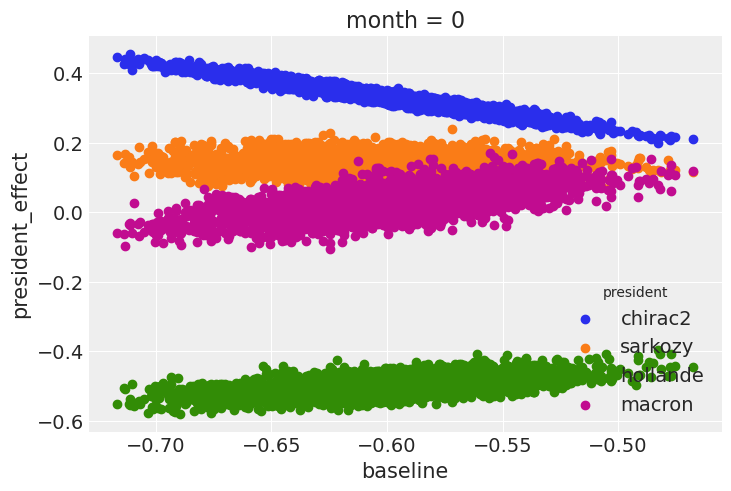

In [60]:
idata.posterior.isel(month=0).plot.scatter("baseline", "president_effect", hue="president");

In [62]:
post_pop = logistic(idata.posterior["mu"].stack(sample=("chain", "draw")))

fig, ax = plt.subplots()
for i in np.random.choice(post_pop.coords["sample"].size, size=1000):
    ax.plot(
        idata.posterior.coords["month"],
        post_pop.isel(sample=i),
        alpha=0.01,
        color="blue",
    )
post_pop.mean("sample").plot(ax=ax, color="orange", lw=2)
ax.set_ylabel("Popularity")
ax.set_xlabel("Months into term");

KeyError: 'mu'

## TODO

- Posterior predictive analysis: distribution of $p_{\mathrm{approve}}$ for each pollster and method. We can plot the approval rates for each poll for each president but we do not except anything to come from it because we mixed all the terms (although we may see a difference due to new pollsters appearing).

- Re-read the paper by Gellman et al. on predicting the US presidential election. We may be able to catch something new given our experience with this first model.

- Try out-of-sample popularity prediction.

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv